## Image Captioning
- Generating Captions for Images

### Steps
- Data Collection
- Understanding the Data
- Data Cleaning
- Loading The Training Set
- Data Preprocessing - Images
- Data Preprocessing - Captions
- Data Preparation using Generator Function
- Word Embeddings
- Model Architecture
- Inference
- Evaluation

In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import keras
import collections
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add

Using TensorFlow backend.


In [2]:
# Read Text Captions

def readTextFile(path):
    with open(path) as f:
        captions = f.read()
    return captions

In [3]:
captions = readTextFile("./Flickr_Data/Flickr_TextData/Flickr8k.token.txt")
captions = captions.split("\n")[:-1]

In [4]:
print(len(captions))

40460


In [5]:
print(captions[0].split('\t'))

['1000268201_693b08cb0e.jpg#0', 'A child in a pink dress is climbing up a set of stairs in an entry way .']


In [6]:
# Dictionary to Map Each Image With The List Of Captions It Has

descriptions = {}

for x in captions:
    first_part, second_part = x.split('\t')
    img_name = first_part.split('.')[0]
    
    # if the image id is already present or not
    if descriptions.get(img_name) is None:
        descriptions[img_name] = []
    
    descriptions[img_name].append(second_part)    

In [7]:
descriptions["1000268201_693b08cb0e"]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

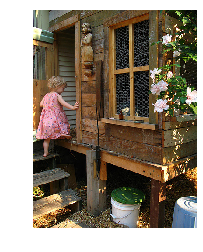

In [8]:
IMG_PATH = "Flickr_Data/Images/"
img = cv2.imread(IMG_PATH + "1000268201_693b08cb0e.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()

#### Data Cleaning

In [9]:
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+", " ", sentence)
    sentence = sentence.split()
    
    sentence = [s for s in sentence if len(s) > 1]
    sentence = " ".join(sentence)
    
    return sentence

In [10]:
# clean_text("A cat is sitting over the house # 64")

In [11]:
# Clean All Captions

for key, caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i] = clean_text(caption_list[i])

In [12]:
descriptions["1000268201_693b08cb0e"]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [13]:
# Write the data to text file

with open("descriptions_1.txt","w") as f:
    f.write(str(descriptions))

### Vocabulary

In [14]:
descriptions = None
with open("descriptions_1.txt",'r') as f:
    descriptions = f.read()
    
json_acceptable_string = descriptions.replace("'", "\"")
descriptions = json.loads(json_acceptable_string)

In [15]:
# print(type(descriptions))

In [16]:
# Vocab

vocab = set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]
print("Vocab Size : %d"%len(vocab))

Vocab Size : 8424


In [17]:
# Total No. of Words Across All The Sentences

total_words = []

for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]
    
print("Total Words %d"%len(total_words))

Total Words 373837


In [18]:
print(total_words[:10])

['child', 'in', 'pink', 'dress', 'is', 'climbing', 'up', 'set', 'of', 'stairs']


In [19]:
# print(vocab)

In [20]:
# Filter Words From the Vocab according to certain threshold frequency

counter = collections.Counter(total_words)
freq_cnt = dict(counter)
print(len(freq_cnt.keys()))

8424


In [21]:
# Sort this dictionary according to the frequency count
sorted_freq_cnt = sorted(freq_cnt.items(), reverse=True, key=lambda x:x[1])

# Filter
threshold = 10
sorted_freq_cnt = [x for x in sorted_freq_cnt if x[1] > threshold]
total_words = [x[0] for x in sorted_freq_cnt]

In [22]:
print(len(total_words))

1845


### Prepare Train/Test Data

In [23]:
train_file_data = readTextFile("Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt")
test_file_data = readTextFile("Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt")

In [24]:
train = [row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
test = [row.split(".")[0] for row in test_file_data.split("\n")[:-1]]

In [25]:
# Prepare Description for The Training Data
# Tweak - Add <s> and <e> token to our training data

train_descriptions = {}

for img_id in train:
    train_descriptions[img_id] = []
    for cap in descriptions[img_id]:
        cap_to_append = "startseq " + cap + " endseq"
        train_descriptions[img_id].append(cap_to_append)

In [26]:
# train_descriptions["1000268201_693b08cb0e"]

## Transfer Learning 
- Images ----> Features
- Text ------> Features

### Step - 1 : Image Feature Extraction

In [27]:
model = ResNet50(weights = "imagenet", input_shape=(224,224,3))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
_____________________________________

In [28]:
model_new = Model(model.input, model.layers[-2].output)

In [29]:
def preprocess_img(img):
    img = image.load_img(img, target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    # Normalisation
    img = preprocess_input(img)
    return img

In [30]:
# img = preprocess_img(IMG_PATH + "1000268201_693b08cb0e.jpg")
# plt.imshow(img[0])
# plt.axis("off")
# plt.show()

In [31]:
def encode_image(img):
    img = preprocess_img(img)
    feature_vector = model_new.predict(img)
    feature_vector = feature_vector.reshape((-1,))
    # print(feature_vector.shape)
    return feature_vector

In [32]:
encode_image(IMG_PATH + "1000268201_693b08cb0e.jpg")

array([0.04154292, 0.17076074, 0.29278558, ..., 0.05089612, 0.3132239 ,
       0.8600747 ], dtype=float32)

In [33]:
encoding_train = {}
start_time = time()
# image_id --> feature_vector extracted from Resnet Image

for ix, img_id in enumerate(train):
    img_path = IMG_PATH + "/" + img_id + ".jpg"
    encoding_train[img_id] = encode_image(img_path)
    if ix % 100 == 0:
        print("Encoding in Progress Time Step : %d"%ix)
        
end_time = time()
print("Total Time Taken : ", end_time - start_time)

Encoding in Progress Time Step : 0
Encoding in Progress Time Step : 100
Encoding in Progress Time Step : 200
Encoding in Progress Time Step : 300
Encoding in Progress Time Step : 400
Encoding in Progress Time Step : 500
Encoding in Progress Time Step : 600
Encoding in Progress Time Step : 700
Encoding in Progress Time Step : 800
Encoding in Progress Time Step : 900
Encoding in Progress Time Step : 1000
Encoding in Progress Time Step : 1100
Encoding in Progress Time Step : 1200
Encoding in Progress Time Step : 1300
Encoding in Progress Time Step : 1400
Encoding in Progress Time Step : 1500
Encoding in Progress Time Step : 1600
Encoding in Progress Time Step : 1700
Encoding in Progress Time Step : 1800
Encoding in Progress Time Step : 1900
Encoding in Progress Time Step : 2000
Encoding in Progress Time Step : 2100
Encoding in Progress Time Step : 2200
Encoding in Progress Time Step : 2300
Encoding in Progress Time Step : 2400
Encoding in Progress Time Step : 2500
Encoding in Progress Tim

In [34]:
# Store Everything To Disk

with open("encoded_train_features.pkl", "wb") as f:
    pickle.dump(encoding_train, f)

In [35]:
encoding_test = {}
start_time = time()
# image_id --> feature_vector extracted from Resnet Image

for ix, img_id in enumerate(test):
    img_path = IMG_PATH + "/" + img_id + ".jpg"
    encoding_test[img_id] = encode_image(img_path)
    if ix % 100 == 0:
        print("Test Encoding in Progress Time Step : %d"%ix)
        
end_time = time()
print("Total Time Taken (Test) : ", end_time - start_time)

Test Encoding in Progress Time Step : 0
Test Encoding in Progress Time Step : 100
Test Encoding in Progress Time Step : 200
Test Encoding in Progress Time Step : 300
Test Encoding in Progress Time Step : 400
Test Encoding in Progress Time Step : 500
Test Encoding in Progress Time Step : 600
Test Encoding in Progress Time Step : 700
Test Encoding in Progress Time Step : 800
Test Encoding in Progress Time Step : 900
Total Time Taken (Test) :  259.31273651123047


In [36]:
with open("encoded_test_features.pkl", "wb") as f:
    pickle.dump(encoding_test, f)

### Data Preprocessing For Captions

In [37]:
#Vocab

len(total_words)

1845

In [38]:
word_to_idx = {}
idx_to_word = {}

for i, word in enumerate(total_words):
    word_to_idx[word] = i+1
    idx_to_word[i+1] = word

In [39]:
# idx_to_word[1]
# word_to_idx["dog"]

In [40]:
print(len(idx_to_word))
print(len(word_to_idx))

1845
1845


In [41]:
# Two Special Words

idx_to_word[1846] = 'startseq'
word_to_idx['startseq'] = 1846

idx_to_word[1847] = 'endseq'
word_to_idx['endseq'] = 1847

In [42]:
vocab_size = len(word_to_idx) + 1
print("Vocab Size : %d"%vocab_size)

Vocab Size : 1848


In [43]:
max_len = 0
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len = max(max_len, len(cap.split()))
print(max_len)

35


### Data Loader (Generator)

In [104]:
def data_generator(train_descriptions, encoding_train, word_to_idx, max_len, batch_size):
    
    X1, X2, Y = [], [], []
    
    n = 0
    while True:
        for key, desc_list in train_descriptions.items():
            n += 1
            
            photo = encoding_train[key]
            for desc in desc_list:
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1, len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    # 0 denotes padding word
                    xi = pad_sequences([xi], maxlen=max_len, value=0, padding='post')[0]
                    yi = to_categorical([yi], num_classes=vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(xi)
                    Y.append(yi)
                    
                if n == batch_size:
                    yield [[np.array(X1), np.array(X2)], np.array(Y)]
                    X1, X2, Y= [], [], []
                    n = 0               

### Word Embeddings

In [105]:
f = open("glove.6B.50d.txt", encoding='utf8')

In [106]:
embedding_index = {}
for line in f:
    values = line.split()
    word = values[0]
    word_embedding = np.array(values[1:], dtype='float')
    embedding_index[word] = word_embedding

In [107]:
f.close()

In [108]:
embedding_index["apple"]

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [109]:
def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size, emb_dim))
    for word, idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
    return matrix

In [110]:
embedding_matrix = get_embedding_matrix()
print(embedding_matrix.shape)

(1848, 50)


In [111]:
# embedding_matrix[1847]

### Model Architecture

In [112]:
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256, activation='relu')(inp_img1)

In [113]:
# Captions as Input
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size, output_dim=50, mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [114]:
decoder1 = add([inp_img2, inp_cap3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# Combined Model
model = Model(inputs=[input_img_features, input_captions], outputs=outputs)

In [115]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 35, 50)       92400       input_9[0][0]                    
__________________________________________________________________________________________________
dropout_7 (Dropout)             (None, 2048)         0           input_8[0][0]                    
__________________________________________________________________________________________________
dropout_8 

In [116]:
# Important Thing -> Embedding Layer

model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [117]:
model.compile(loss='categorical_crossentropy', optimizer="adam")

### Training of Model

In [118]:
epochs = 20
batch_size = 3
steps = len(train_descriptions)//batch_size

In [119]:
for i in range(epochs):
    generator = data_generator(train_descriptions, encoding_train, word_to_idx, max_len, batch_size)
    model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
    model.save('./model_weights/model_' + str(i) + '.h5')

Epoch 1/1
2000/2000 [==============================] - 512s 256ms/step - loss: 4.3113
Epoch 1/1
2000/2000 [==============================] - 518s 259ms/step - loss: 3.5864
Epoch 1/1
2000/2000 [==============================] - 530s 265ms/step - loss: 3.3270
Epoch 1/1
2000/2000 [==============================] - 521s 260ms/step - loss: 3.1681
Epoch 1/1
2000/2000 [==============================] - 524s 262ms/step - loss: 3.0548
Epoch 1/1
2000/2000 [==============================] - 516s 258ms/step - loss: 2.9659
Epoch 1/1
2000/2000 [==============================] - 517s 259ms/step - loss: 2.8975
Epoch 1/1
2000/2000 [==============================] - 517s 258ms/step - loss: 2.8422
Epoch 1/1
2000/2000 [==============================] - 517s 258ms/step - loss: 2.7949
Epoch 1/1
2000/2000 [==============================] - 519s 259ms/step - loss: 2.7553
Epoch 1/1
2000/2000 [==============================] - 515s 258ms/step - loss: 2.7217
Epoch 1/1
2000/2000 [==============================] -

In [120]:
model = load_model('./model_weights/model_9.h5')

### Predictions

In [122]:
def predict_caption(photo):
    
    in_text = "startseq"
    
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence], maxlen=max_len, padding='post')
        
        ypred = model.predict([photo,sequence])
        ypred = ypred.argmax() # Taking word with max prob always - Greedy Sampling
        word = idx_to_word[ypred]
        in_text += ' ' + word
        
        if word == 'endseq':
            break
    
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    
    return final_caption

two children are playing in the snow


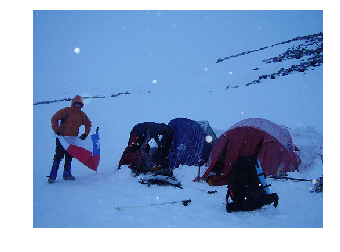

man in orange shirt and white shorts and white shirt is hitting baseball ball


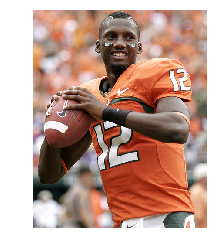

group of people gather for picture in front of building


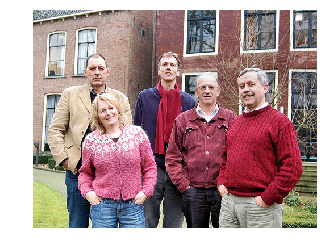

the dog is leaping through the air


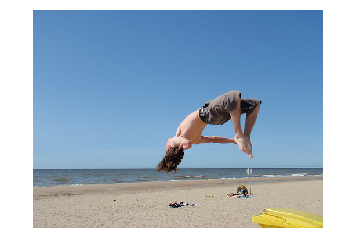

brown dog is running through field of grass


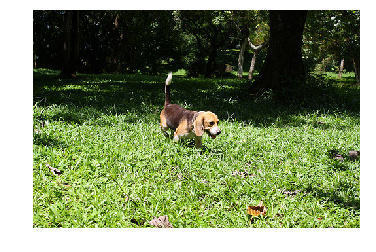

young boy wearing pink shirt is jumping on the grass


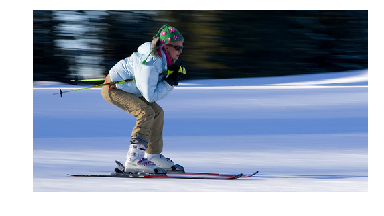

man jumps off of helicopter into the air


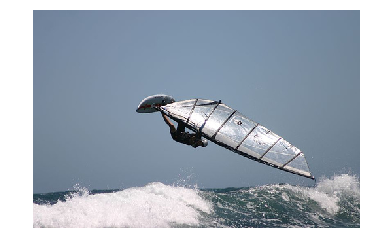

black and white dog is running through field of grass


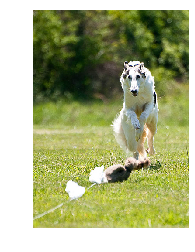

man with beard and glasses is playing with his hand


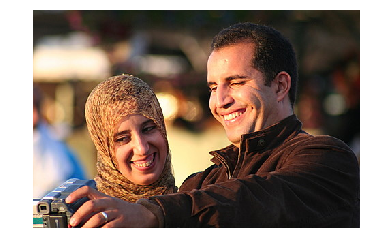

man in red shirt climbs rock face


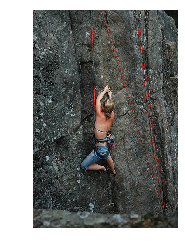

two men sit on top of grassy hill


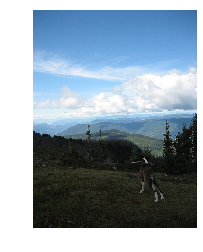

man is rock climbing


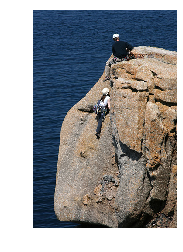

two dogs are running around along dirt track


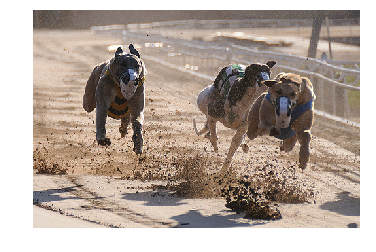

dog jumps over hurdle


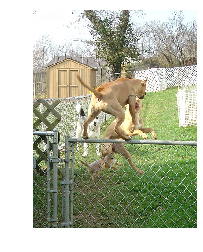

man with mask and white and white shirt is wearing purple shirt


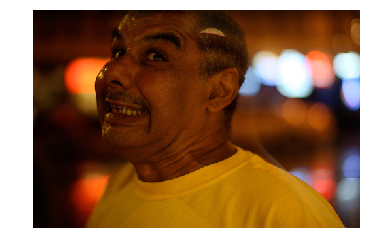

In [123]:
# Pick some random images and See Results

for i in range(15):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoding_test[img_name].reshape((1,2048))
    
    i = plt.imread("Flickr_Data/Images/" + img_name + ".jpg")
    caption = predict_caption(photo_2048)
    print(caption)
    plt.imshow(i)
    plt.axis("off")
    plt.show()
    
    
    